### Step 1 - Prepare all the imports we'll need

In [17]:
import base64
from base64 import b64encode

import glob
import io

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import gymnasium as gym
import random
import sys

from IPython.display import HTML
from IPython import display
from IPython.display import clear_output

from gym.wrappers.record_video import RecordVideo
from gym_minigrid.wrappers import *
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX


plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%reload_ext autoreload

### Step 2 - Create your first Grid World Environment

In [18]:
env = gym.make('MiniGrid-Empty-5x5-v0', render_mode="rgb_array")

### Step 3 - Interact with the environment

In [19]:
env.reset()
action = env.action_space.sample()
obs, reward, terminated, truncated, info  = env.step(action)

print("Action:", action)
print("Observation:", obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info:", info)

Action: 0
Observation: {'image': array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]]], dtype=uint8), 'directi

### Step 4 - Let's get a glimpse of this World

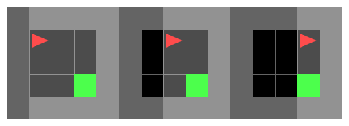

In [20]:
env.reset()

before_img = env.render()
plt.imshow(before_img);

action = env.actions.forward
obs, reward, terminated, truncated, info  = env.step(action)

after_img = env.render()

action = env.actions.forward
obs, reward, terminated, truncated, info  = env.step(action)

final_img = env.render()

plt.imshow(np.concatenate([before_img, after_img, final_img], 1));
plt.axis('off')
plt.show()


### Step 5 - Redefine the observations to get one-dimensional array

In [21]:
class FlatObsWrapper(gym.core.ObservationWrapper):
    def __init__(self, env, max_env_steps=50):
        super().__init__(env)        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        return self.unwrapped.render(*args, **kwargs)

### Step 6 - Check you world again

Observation: [10  0  1  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  8  1  0] , Observation Shape:  (108,)
Reward: 0
terminated: False
truncated: False
info {}
Image shape: (256, 256, 3)


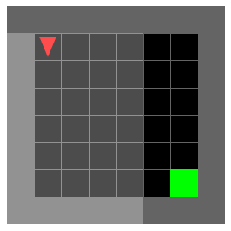

In [22]:
# Make use of the Flat Observable in your MiniGrid Environment
env = FlatObsWrapper(gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array"), max_env_steps = 200)

# Reset the environment
env.reset()

# Select the action right
action = env.actions.right

# Take a step in the environment and store it in appropriate variables
obs, reward, terminated, truncated, info  = env.step(action)


# Render the current state of the environment
img = env.render()
print('Observation:', obs, ', Observation Shape: ', obs.shape)
print('Reward:', reward)
print('terminated:', terminated)
print('truncated:', truncated)
print('info', info)
print('Image shape:', img.shape)
plt.imshow(img);
plt.axis('off')  # Hide axes for better visualization
plt.show()

### Step 7 - Define a random policy

In [23]:
# Random policy - nothing special
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self, *unused_args):
        return self.action_space.sample()

### Step 8 - Run it

Total reward: 0
Total length: 11
Reward: 0
Terminated: False
Truncated: True
Info {}


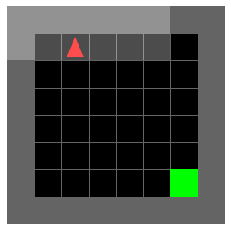

In [26]:
# This function renders images of rollout of a given policy and environment
def log_policy_rollout(policy, env):
    # Create environment with flat observation
    obs, reward, terminated, truncated, info = [], -1, False, False, {}
    
    # Initialize environment
    observation = env.reset()
    episode_reward = 0
    episode_length = 0
    
    truncated = False
    while not truncated:
        # Take a step
        action = policy.act(observation)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        episode_length += 1
        
        print('Reward:', reward)
        print('Terminated:', terminated)
        print('Truncated:', truncated)
        print('Info', info)
        print('Step Nr.: ', episode_length)
        if episode_length > 10:
            truncated = True
        # Display what you see
        plt.imshow(env.render());
        plt.axis('off')
        plt.show()
        plt.pause(1)  # Pause for 1 second
        clear_output(wait=True) 
        
    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    return obs, reward, terminated, truncated, info
    
# Test that the logging function is working
test_env_name = 'MiniGrid-Empty-8x8-v0'
env = FlatObsWrapper(gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array"), max_env_steps = 200)
rand_policy = RandPolicy(env.action_space)

obs, reward, terminated, truncated, info = log_policy_rollout(rand_policy, env)
print('Reward:', reward)
print('Terminated:', terminated)
print('Truncated:', truncated)
print('Info', info)

plt.imshow(env.render());
plt.axis('off')
plt.show()

### Step 9 - Improve what you see, add a video

In [27]:
def wrap_env(env):
    env = RecordVideo(env, './video',
                      episode_trigger = lambda episode_number: True, 
                      video_length=0, 
                      name_prefix="full_episode")
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name,render_mode="rgb_array"), max_env_steps=200))

### Step 11 - Prove it works!

In [30]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Plots videos of rollouts (episodes) of your random policy and environment
def log_policy_rollout(policy, env_name):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name)
    obs, reward, terminated, truncated, info = [], -1, False, False, {}
    
    # Initialize environment
    observation = env.reset()
    actions = [2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2]
    terminated = False
    episode_reward = 0
    episode_length = 0

    for i in range(len(actions)):
    
        # Take a step
        action = policy.act(observation)
        # obs, reward, terminated, truncated, info = env.step(action)
        obs, reward, terminated, truncated, info = env.step(actions[i])
        episode_reward += reward
        episode_length += 1
        if i == len(actions):
             show_video()
             return obs, reward, terminated, truncated, info
            

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    show_video()
    return obs, reward, terminated, truncated, info
    
# Test the logging function
test_env_name = 'MiniGrid-Empty-8x8-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)

obs, reward, terminated, truncated, info = log_policy_rollout(rand_policy, test_env_name)
print('Reward:', reward)
print('Terminated:', terminated)
print('Truncated:', truncated)
print('Info', info)

/usr/local/lib/python3.9/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/victor/Documents/python-projects/medium-py/minigrid-world-envs/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/victor/Documents/python-projects/medium-py/minigrid-world-envs/video/full_episode-episode-0.mp4.
Moviepy - Writing video /Users/victor/Documents/python-projects/medium-py/minigrid-world-envs/video/full_episode-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/victor/Documents/python-projects/medium-py/minigrid-world-envs/video/full_episode-episode-0.mp4
Total reward: 0.946
Total length: 12


Reward: 0.946
Terminated: True
Truncated: False
Info {}
